### GASS UVW

Notebook to test the uv coverage computation for an observation with a radio interferometer.

In [9]:
using Distances , Random 
using PyCall
using DataFrames
#using LinearAlgebra
using LsqFit
using FFTW

using StatsBase

import CSV 

#rootdir = "/home/stephane/alma/ArrayConfig/GASS"
rootdir = "/home/stephane/Science/ALMA/ArrayConfig/GASS"

push!(LOAD_PATH,"$rootdir/master/src")
using GASS

import PyPlot

@pyimport astropy.coordinates as coord
@pyimport astropy.modeling.models as am
@pyimport astropy.modeling.fitting as mf

@pyimport numpy as np


## directory
datadir = "$rootdir/master/data"
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

In [10]:
struct _synthbeam
    bx::Float64
    by::Float64
    ar::Float64
    e::Float64
    sidelobe::Float64
end

### UVW methods

Several to manipulate and analyze uv-coverage in (radio) interferometry. The examples are taken from ALMA, a (sub-) millieter radio interferometer located in the desert of Atacama, Chile

In [11]:
## baseline coordinates
## arr: DataFrames with at least :X, :Y, :Z
## check at https://web.njit.edu/~gary/728/Lecture6.html

function _calc_baselines(arr::AbstractDataFrame , lat=-23.0262015)
    
    coordinates= vcat(hcat(convert(Vector{Float64},arr[:X]))' ,
        hcat(convert(Vector{Float64},arr[:Y]))' ,
        hcat(convert(Vector{Float64},arr[:Z]))')
    rot= [0 -sind(lat) cosd(lat) ; 1 0 0 ; 0  cosd(lat)  sind(lat)]
    xyz= *(rot,coordinates)
    
    Nc= size(xyz)
    Nbl= convert(Int64,(Nc[2]*(Nc[2]-1))/2)   
    bl= zeros(Float64,3,2Nbl)   ## symmetry of the bl
    
    ibl= 1
    for i in 1:Nc[2]
        for j in i+1:Nc[2]
            bl[1,ibl]= xyz[1,i]-xyz[1,j] ; bl[1,ibl+Nbl]= xyz[1,j]-xyz[1,i]
            bl[2,ibl]= xyz[2,i]-xyz[2,j] ; bl[2,ibl+Nbl]= xyz[2,j]-xyz[2,i]
            bl[3,ibl]= xyz[3,i]-xyz[3,j] ; bl[3,ibl+Nbl]= xyz[3,j]-xyz[3,i]
            ibl += 1
        end
    end
    return(bl)
end

####
##  bl: baselines computed in calc_baselines
### h0: hour angle in degrees
### d0: source declination in degrees
### only snapshot still...
function _calc_uv(bl, h0=0, d0=-50)
    
    h0 *= 15   #hours to degree
    proj= [sind(h0) cosd(h0) 0 ; -sind(d0)cosd(h0) sind(d0)sind(h0) cosd(d0) ; cosd(d0)cosd(h0) -cosd(d0)sind(h0) sind(d0)]
    uv= *(proj, bl)
    return(uv)
end

function calc_uv_coverage
    ## will compute the uv_coverage with an observing and sampling time ..
    ## for now only a snapshot.
end

calc_uv_coverage (generic function with 0 methods)

In [12]:
## Compute properties of a given UV coverage.
## a first shot is by using numpy
function mgrid(xsize, ysize)
    xx= []
    for i in 0:xsize
        push!(xx,fill!(zeros(Int64,xsize+1),i))
    end
    
    yy= []
    for j in 0:ysize
        push!(yy,collect(0:ysize))
    end
    
    println(size(xx))
    println(size(yy))
    return(xx,yy)
end

function pyuv_beamproperties(uv; npix=512, sizefit=60)
    lmax= maximum(abs.(uv))
    dx= 2lmax  / npix
    binx= range(-lmax,stop=lmax,length=npix)
    ds = dx / (299792458.0 / (100 * 1e9))
    dr= 180*3600/(π*npix*ds)   ## arcsec
    println(dr)
    gaussian_sigma_to_fwhm=2.3548200450309493

    H, xd, yd = np.histogram2d(uv[1,:], uv[2,:], bins=(collect(binx), collect(binx)))
    
    ## appl ying Briggs weighting with a Robust parameter of 0.5
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H.>0].^2)/Hsum
    f2= (5*10^0.5)^2 * H2sum
    H2 = H ./ (1 .+ f2 .* H)
    
    h = np.fft[:fft2](H2)
    hshift = abs.(real.(np.fft[:fftshift](h)))
    
    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    
    x, y = mgrid(sizefit, sizefit)
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    p_init = am.Gaussian2D(amplitude=maximum(hshiftcut),x_mean=sizefit/2, y_mean=sizefit/2,
        x_stddev=1, y_stddev=1)
    
    fit_p = mf.LevMarLSQFitter()
    p = fit_p(p_init, x, y, hshiftcut, maxiter=100)
    println(p)
    println(p[:x_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:y_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:theta]*180/π)
    
    return(hshiftcut)
end



pyuv_beamproperties (generic function with 1 method)

In [13]:
###################################
function pyuv_beampropertiesTEST(uv; npix=512, sizefit=60 , robust=2)
    lmax= maximum(abs.(uv))
    dx= 16lmax  / npix
    binx= range(-8lmax,stop=8lmax,length=npix)
    ds = dx / (299792458.0 / (100 * 1e9))
    println(dx*npix)
    dr= 180*3600/(π*npix*ds)   ## arcsec
    println(dr)
    gaussian_sigma_to_fwhm=2.3548200450309493

    H, xd, yd = np.histogram2d(uv[1,:], uv[2,:], bins=(collect(binx), collect(binx)))
    
    ## appl ying Briggs weighting with a Robust parameter of 0.5
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H .> 0].^2)/Hsum
    
    f2= (5 * 10.0^(-robust))^2 * H2sum 
    H2 = H ./ (1 .+ f2 .* H)

    #h = np.fft[:fft2](H2)
    h= fft(H2)
    
    # hshift = abs.(real.(np.fft[:fftshift](h)))
    hshift= fftshift(abs.(real.(h)))
 
    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    println(coord_a)
    
    x, y = mgrid(sizefit, sizefit)
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    p_init = am.Gaussian2D(amplitude=maximum(hshiftcut),x_mean=sizefit/2, y_mean=sizefit/2,
        x_stddev=1, y_stddev=1)
    
    fit_p = mf.LevMarLSQFitter()
    p = fit_p(p_init, x, y, hshiftcut, maxiter=100)
    println(p)
    println(p[:y_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:x_stddev]*dr*gaussian_sigma_to_fwhm)
    println(p[:theta]*180/π)
    
    return(hshiftcut)
end


pyuv_beampropertiesTEST (generic function with 1 method)

In [14]:
################################
## setup the npix,fov, freq, etc for the beam extraction from the uv
## coverage. It is based on the uniform weighting 2/FOV for the uv-cell
##
function _calc_dirtybeam(uv, npix=511, sizefit=63 ; robust=2)
    println("## UV gridding and weighting...")
    c= 299792458.0  ; ν= 100*1e9 ; λ= c / ν
    D= 12 ; PB= 1.13 * λ / D
    duv= 2/(PB*npix) ; ds= duv/λ
    dr= 180*3600/(π*ds*npix)
    lmax= maximum(abs.(uv))

    if (duv*npix/2) < lmax
        println("##UV-gridding error, npix too small...")
    end
    
    binuv= range(-duv*npix/2, stop=duv*npix/2,npix, length=npix)
    Hh= fit(Histogram, (uv[1,:] , uv[2,:]) , (binuv , binuv))
    H= Hh.weights

    ## Robust weighting R (Briggs)
    ## R=-2 : uniform
    ## R=2 : naturañ
    ## R=0.5 : "briggs"
    Hsum= sum(H)
    H2sum= sum(1 ./ H[H .> 0].^2)/Hsum
    f2= (5 * 10.0^(-robust))^2 * H2sum 
    H2 = H ./ (1 .+ f2 .* H)
 
    h= fft(H2)
    hshift= fftshift(abs.(real.(h)))

    center= npix/2
    coord_a= convert(Int64,center-sizefit/2)
    coord_b= convert(Int64,center+sizefit/2)
    println(coord_a)
    println(coord_b)
    
    hshiftcut= hshift'[coord_a:coord_b, coord_a:coord_b]
    println("###")
    return(hshiftcut , dr)
end


_calc_dirtybeam (generic function with 3 methods)

In [15]:
## fitting of the Gaussian 2D for the beam
## assuming offset=0 for the beam

function _gaussian2D(x,y, amplitude, xo, yo, σx, σy, θ)
    
    a = (cosd(θ)^2)/(2σx^2) + (sind(θ)^2)/(2*σy^2)
    b = -(sind(2θ))/(2σx^2) - (sind(2θ))/(2σy^2)
    c = (sind(θ)^2)/(2σx^2) + (cosd(θ)^2)/(2σy^2)
    gauss2d= amplitude*exp( -( a*((x-xo)^2) + 2b*(x-xo)*(y-yo) + c*((y-yo)^2)) )
    return(gauss2d)
end

#################################
function _fit_beam(beam , dr)
    bs= size(beam)
    h= reshape(beam,(bs[1]*bs[2],))
    
    xy= zeros(Float64,bs[1]*bs[2], 2)
    
    for i in 1:bs[1]
        for j in 1:bs[2]
            xy[(i-1)*bs[1]+j,1]= i
        end
    end
    
    for i in 1:bs[1]
        for j in 1:bs[2]
            xy[(i-1)*bs[1]+j,2]= bs[2]+1-j
        end
    end        
    
    @. multimodel(x, p) = _gaussian2D(x[:,1], x[:,2], p[1], p[2] , p[3] , p[4] , p[5], p[6])
    p0 = [maximum(beam) , bs[1]/2 , bs[2]/2 , 1, 1, 0]
    f= curve_fit(multimodel, xy, h, p0)
    println(f.param)
    
    gaussian_sigma_to_fwhm=2.3548200450309493
    println(f.param[4]*dr*gaussian_sigma_to_fwhm)
    println(f.param[5]*dr*gaussian_sigma_to_fwhm)
    println(f.param[6])
    println("sidelobe:", maximum(f.resid * 100 / f.param[1]))
    
    bx= f.param[4]*dr*gaussian_sigma_to_fwhm
    by= f.param[5]*dr*gaussian_sigma_to_fwhm  
    e= max(bx/by, by/bx)
    ar= sqrt(bx*by)
    sidelobe= maximum(f.resid * 100 / f.param[1])
    b = _synthbeam(bx, by,ar,e, sidelobe)
    
    return(fit , f.resid , b)
end

_fit_beam (generic function with 1 method)

## Input Parameters for GASS 
## Configuration file: ../master/data/O-3.cfg 
## Obs. Latitude: -23.026 
## Source Declination: -50.0 
## HA: -1.0 
## Subarray number: 4 
3635.8990983102462
0.17007246788682567
64
(128,)
(128,)
PyObject <Gaussian2D(amplitude=2512.11561445, x_mean=64., y_mean=64., x_stddev=7.48729985, y_stddev=8.25714644, theta=6.68860868)>
PyObject 3.3069050449334916
PyObject 2.9985891402928466
PyObject 383.22904793373954
GASS

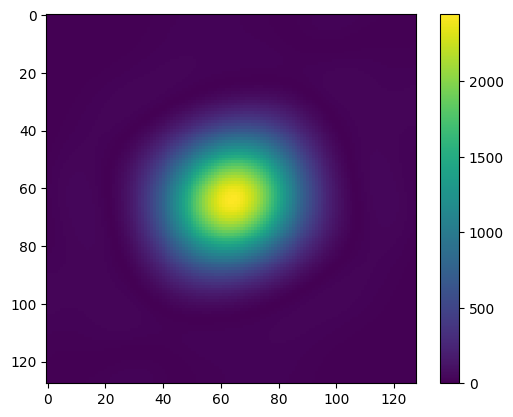

.synthbeam(3.200828223219085, 2.9920191858776217, 3.0946630599420804, 1.0697886692461884, 2.6352894914219425)


In [16]:
### Main
macro main(inpfile)
    cfg = read_cfg(inpfile , verbose=true)
    
    ## array test
    bl= calc_baselines(cfg.arr)
    uv= calc_uv(bl, cfg.obs.Source_Hour_Angle ,  cfg.obs.Source_Declination)
    #uv= _calc_uv(bl, 0.0, -50)

    dirty= pyuv_beampropertiesTEST(uv , npix=255, sizefit=127, robust=2)
    h , dr=  calc_dirtybeam(uv , 255, 127, robust=2)
    #f, residuals , b= _fit_beam(h , dr)
    b= fit_beam(h , dr)
    println(b)
    
    PyPlot.imshow(h)
    PyPlot.colorbar()
    PyPlot.show()
    
end

@main("../master/data/GA_Inputs_O-3.txt.julia")